In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import pandas as pd
import time
import pyodbc
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import f1_score, accuracy_score
from random import randint
from utils import *


In [2]:
server = 'localhost\SQLEXPRESS'
database = 'nba_game_data'

In [3]:
player_id = '201142'
pt_thresh = 25.5
opp = 'BKN'

In [4]:
sql = f'''
with base as (
SELECT
       pgl.[SEASON_YEAR]
      ,pgl.[PLAYER_ID]
      ,pgl.[PLAYER_NAME]
      ,pgl.[NICKNAME]
      ,pgl.[TEAM_ID]
      ,pgl.[TEAM_ABBREVIATION]
      ,pgl.[TEAM_NAME]
      ,pgl.[GAME_ID]
      ,pgl.[GAME_DATE]
      ,LAG (pgl.[GAME_DATE]) OVER (PARTITION BY pgl.[PLAYER_ID] ORDER BY pgl.[GAME_DATE]) AS Last_Game_Played
      ,pgl.[MATCHUP]
      ,pgl.[WL]
      ,pgl.[yearSeason]
      ,CASE WHEN PGL.WL = 'W' THEN 1 ELSE 0 END AS WLInt
      ,LAG (CASE WHEN PGL.WL = 'W' THEN 1 ELSE 0 END) OVER (PARTITION BY pgl.[PLAYER_ID] ORDER BY pgl.[GAME_DATE]) AS did_they_win_last_game
     ,PTS
  FROM [nba_game_data].[dbo].[PlayerGameLogs] pgl


  WHERE pgl.PLAYER_ID = '{player_id}'
  )
  SELECT 
 [PLAYER_ID]
,[GAME_ID]
,[GAME_DATE]
,yearSeason
,[PTS]
,CASE WHEN [PTS] > {pt_thresh} THEN 1 ELSE 0 END AS PtsThreshold
,SUM(WLInt) OVER (PARTITION BY PLAYER_ID ORDER BY GAME_DATE ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING) AS RunningGamesWonLast10
,DATEDIFF(day, Last_Game_Played,[GAME_DATE])-1 AS daysRest
,did_they_win_last_game

  FROM base

  order by GAME_DATE

'''
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';')
cursor = cnxn.cursor()
data = pd.read_sql(sql,cnxn)

In [5]:
sql = f'''
with base as (
SELECT
       pgl.[SEASON_YEAR]
      ,pgl.[PLAYER_ID]
      ,pgl.[PLAYER_NAME]
      ,pgl.[NICKNAME]
      ,pgl.[TEAM_ID]
      ,pgl.[TEAM_ABBREVIATION]
      ,pgl.[TEAM_NAME]
      ,pgl.[GAME_ID]
      ,pgl.[GAME_DATE]
      ,LAG (pgl.[GAME_DATE]) OVER (PARTITION BY pgl.[PLAYER_ID] ORDER BY pgl.[GAME_DATE]) AS Last_Game_Played
      ,pgl.[MATCHUP]
      ,pgl.[WL]
      ,CASE WHEN PGL.WL = 'W' THEN 1 ELSE 0 END AS WLInt
  

  FROM [nba_game_data].[dbo].[PlayerGameLogs] pgl



  WHERE pgl.PLAYER_ID = '{player_id}'
  )
  SELECT 
 [PLAYER_ID]
,[GAME_ID]
,SUM(WLInt) OVER (PARTITION BY PLAYER_ID ORDER BY GAME_DATE ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS RunningGamesWonLast10
,DATEDIFF(day, [GAME_DATE], GETDATE())-1 AS daysRest
,WLInt AS did_they_win_last_game

  FROM base

  order by GAME_DATE

'''
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';')
cursor = cnxn.cursor()
pred = pd.read_sql(sql,cnxn)

In [6]:
numbers = [5,20]

for i in numbers:
    temp = get_player_last_n_data(player_id,i)
    temp = temp.drop(columns = ['TEAM_ABBREVIATION','oppAbrv'])
    data = pd.merge(data, temp, on=['PLAYER_ID', 'GAME_ID'])
    del temp
    
    temp = get_pred_data(player_id,i,opp)
    
    pred = pd.merge(pred, temp, on=['PLAYER_ID', 'GAME_ID'])
    del temp

In [7]:
pred = pred.iloc[-1:].drop(columns=['PLAYER_ID','GAME_ID'])

In [8]:
pt_thresh

25.5

In [9]:
filtered = data.loc[(data['PTS'] < (pt_thresh - 3)) | (data['PTS'] > (pt_thresh + 3))]#['PTS']
df_season_buffer = filtered.sort_values(by='GAME_DATE').tail(82)#.loc[filtered['yearSeason']=='2024']

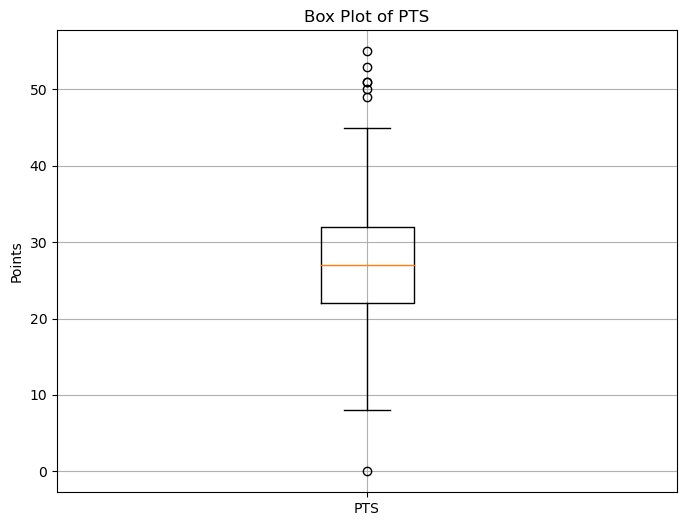

In [10]:
# Creating a box plot for the 'PTS' column
plt.figure(figsize=(8, 6))
plt.boxplot(data['PTS'])
plt.title('Box Plot of PTS')
plt.ylabel('Points')
plt.xticks([1], ['PTS'])
plt.grid(True)
plt.show()



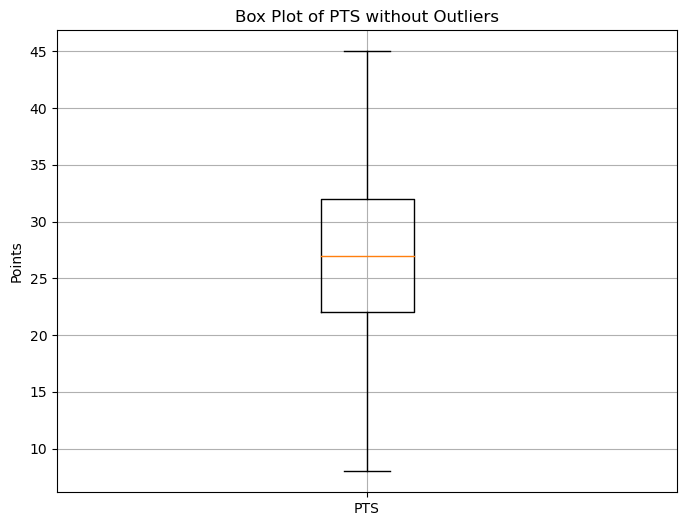

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Determine outliers using the IQR method
Q1 = data['PTS'].quantile(0.25)
Q3 = data['PTS'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data = data[(data['PTS'] >= lower_bound) &
                                           (data['PTS'] <= upper_bound)]

# Creating a new boxplot without the outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data['PTS'])
plt.title('Box Plot of PTS without Outliers')
plt.ylabel('Points')
plt.xticks([1], ['PTS'])
plt.grid(True)
plt.show()


In [12]:
df_last_60 = data.tail(60)
df_last_60 = df_last_60.drop(columns=['PLAYER_ID','GAME_ID','GAME_DATE','PTS','yearSeason'])
df_season = data.loc[data['yearSeason']=='2024']
df_season = df_season.drop(columns=['PLAYER_ID','GAME_ID','GAME_DATE','PTS','yearSeason'])
df = data.drop(columns=['PLAYER_ID','GAME_ID','GAME_DATE','PTS','yearSeason'])
df = df.iloc[1:]
df_season_buffer = df_season_buffer.drop(columns=['PLAYER_ID','GAME_ID','GAME_DATE','PTS','yearSeason'])

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import LeaveOneOut, KFold
import numpy as np

# Function to select top 'n' features
def select_top_n_features(X, y, n):
    model = RandomForestClassifier()
    model.fit(X, y)

    selector = SelectFromModel(model, max_features=n, prefit=True)
    X_selected = selector.transform(X)
    return X_selected, selector

# Modified function to evaluate models with feature selection
def evaluate_models_with_feature_selection(df_feat, X, y, n_features, dataset_type, type_data):
    global final_model, final_model_cv_score, final_model_score, final_scoring_type, final_dataset, type_of_data, base_score, final_X, final_y, final_x_transformer

    X_selected, selector = select_top_n_features(X, y, n_features)
    scoring_method = 'precision'  # Change to 'f1_macro', 'f1_micro', or 'f1_weighted' for multi-class

    if len(df_feat) < 100:
        cv_strategy = LeaveOneOut()
    else:
        cv_strategy = LeaveOneOut()#KFold(n_splits=15, shuffle=True, random_state=42)

    for name, model in models.items():
        cv_scores = np.mean(cross_val_score(model, X_selected, y, cv=cv_strategy, scoring=scoring_method, n_jobs=-1))
        print(name,cv_scores)
        if name == 'Bayesian' and cv_scores == final_model_cv_score:
            cv_scores += 0.001

        if cv_scores > final_model_cv_score:
            final_model = name
            final_model_cv_score = cv_scores
            final_model_score = cv_scores - base_score
            final_scoring_type = 'loo' if len(df_feat) < 100 else 'cv'
            final_dataset = dataset_type
            type_of_data = type_data
            final_X = X_selected
            final_y = y
            final_x_transformer = selector


# Function to evaluate models
def evaluate_models(df_current, X, y, dataset_type, type_data, pca_transformer ):
    global final_model, final_model_cv_score, final_model_score, final_scoring_type, final_dataset, type_of_data, base_score, final_X, final_y, final_x_transformer

    scoring_method = 'precision'  # Change to 'f1_macro', 'f1_micro', or 'f1_weighted' for multi-class

    if len(df_current) < 100:
        cv_strategy = LeaveOneOut()
    else:
        cv_strategy = LeaveOneOut()#KFold(n_splits=15, shuffle=True, random_state=42)

    for name, model in models.items():
        cv_scores = np.mean(cross_val_score(model, X, y, cv=cv_strategy, scoring=scoring_method, n_jobs=-1))
        print(name,cv_scores)
        if name == 'Bayesian' and cv_scores == final_model_cv_score:
            cv_scores += 0.001

        if cv_scores > final_model_cv_score:
            final_model = name
            final_model_cv_score = cv_scores
            final_model_score = cv_scores - base_score
            final_scoring_type = 'loo' if len(df_current) < 100 else 'cv'
            final_dataset = dataset_type
            type_of_data = type_data
            final_X = X
            final_y = y
            final_x_transformer = pca_transformer


In [42]:
# Placeholder function for neural network
def create_neural_network(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
#     "Logistic Regression": LogisticRegression(),
#     "SVM": SVC(probability=True),
#     "Naive Bayes": GaussianNB(),
#     "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
#     "Gradient Boosting Machines": GradientBoostingClassifier(),
#     "KNN": KNeighborsClassifier(),
#     "AdaBoost": AdaBoostClassifier(),
#     "XGBoost": XGBClassifier(n_jobs=-1),
#     "CatBoost": CatBoostClassifier(thread_count=-1),
#     "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
#     "SGD Classifier": SGDClassifier(loss='log', n_jobs=-1)
#     "Neural Network (TensorFlow)": create_neural_network  # Assuming input_shape is defined elsewhere
}

# Note: The neural network model requires additional setup like defining input_shape based on your specific data.

In [43]:
base_score = sum(df['PtsThreshold'])/ len(df) 
final_model = ''
final_model_cv_score = 0
final_model_score = 0
final_scoring_type = 'career'
final_dataset = -999
type_of_data = 'noraml_normal'
final_x_transformer = None


final_X = None
final_y = None



In [44]:
sum(df['PtsThreshold'])/ len(df) 

0.6057906458797327

In [45]:
base_score = sum(df_last_60['PtsThreshold'])/ len(df_last_60) 

max_feat_5_pct = round(len(df)*.05)
max_feat_10_pct = round(len(df)*.10)

df_last_60.fillna(df_last_60.mean(), inplace=True)

# Separating features and target
X = df_last_60.drop('PtsThreshold', axis=1)
y = df_last_60['PtsThreshold']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction
pca = PCA(n_components=0.95) # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Dimensionality Reduction
pca_n_com = PCA(n_components=max_feat_5_pct) # Adjust the number of components as needed
X_pca_n_comp = pca_n_com.fit_transform(X_scaled)


# # Evaluating models without dimensionality reduction
# print("Evaluating models without dimensionality reduction:")
# evaluate_models(df_last_60,X_scaled, y,'60','normal_normal')

# Evaluating models with dimensionality reduction
print("\nEvaluating models with dimensionality reduction:")
evaluate_models(df_last_60,X_pca, y,'60','pca_95', pca_transformer = pca)

# Evaluating models with dimensionality reduction only n comp
print("\nEvaluating models with dimensionality reduction only n comp:")
evaluate_models(df_last_60,X_pca_n_comp, y,'60','pca_n',pca_transformer = pca_n_com)

# Example of how to use the modified function
print("\nEvaluating models with top 5% feature selection:")
evaluate_models_with_feature_selection(df_last_60,X_scaled, y, max_feat_5_pct,'60','selection_5')  

# Example of how to use the modified function
print("\nEvaluating models with top 10% feature selection:")
evaluate_models_with_feature_selection(df_last_60,X_scaled, y, max_feat_10_pct,'60','selection_10')  


Evaluating models with dimensionality reduction:
Random Forest 0.65
Quadratic Discriminant Analysis 0.6666666666666666

Evaluating models with dimensionality reduction only n comp:
Random Forest 0.6166666666666667
Quadratic Discriminant Analysis 0.6666666666666666

Evaluating models with top 5% feature selection:
Random Forest 0.5833333333333334
Quadratic Discriminant Analysis 0.6666666666666666

Evaluating models with top 10% feature selection:
Random Forest 0.5833333333333334
Quadratic Discriminant Analysis 0.25


In [18]:
sum(df_last_60['PtsThreshold'])/ len(df_last_60) 

0.6666666666666666

In [28]:
df_season.fillna(df_season.mean(), inplace=True)
base_score = sum(df_season['PtsThreshold'])/ len(df_season) 

# Separating features and target
X = df_season.drop('PtsThreshold', axis=1)
y = df_season['PtsThreshold']

max_feat_5_pct = round(len(df_season)*.05)
max_feat_10_pct = round(len(df_season)*.10)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction
pca = PCA(n_components=0.95) # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Dimensionality Reduction
pca_n_com = PCA(n_components=max_feat_10_pct) # Adjust the number of components as needed
X_pca_n_comp = pca_n_com.fit_transform(X_scaled)


# # Evaluating models without dimensionality reduction
# print("Evaluating models without dimensionality reduction:")
# evaluate_models(df_season,X_scaled, y, 'season','normal_normal')

# Evaluating models with dimensionality reduction
print("\nEvaluating models with dimensionality reduction:",'pca_95', pca)
evaluate_models(df_season,X_pca, y,'season','pca_95',pca_transformer = pca)

# Evaluating models with dimensionality reduction only n comp
print("\nEvaluating models with dimensionality reduction only n comp:",pca_n_com)
evaluate_models(df_season,X_pca_n_comp, y,'season','pca_n',pca_transformer = pca_n_com)

# Example of how to use the modified function
print("\nEvaluating models with top 5% feature selection:")
evaluate_models_with_feature_selection(df_season,X_scaled, y, max_feat_5_pct,'season','selection_5')  

# Example of how to use the modified function
print("\nEvaluating models with top 10% feature selection:")
evaluate_models_with_feature_selection(df_season,X_scaled, y, max_feat_10_pct,'season','selection_10')  


Evaluating models with dimensionality reduction: pca_95 PCA(n_components=0.95)
Quadratic Discriminant Analysis 0.725

Evaluating models with dimensionality reduction only n comp: PCA(n_components=4)
Quadratic Discriminant Analysis 0.6

Evaluating models with top 5% feature selection:
Quadratic Discriminant Analysis 0.7

Evaluating models with top 10% feature selection:
Quadratic Discriminant Analysis 0.675


In [20]:
sum(df_season['PtsThreshold'])/ len(df_season) 

0.725

In [48]:
base_score = sum(df_season_buffer['PtsThreshold'])/ len(df_season_buffer) 

max_feat_5_pct = round(len(df_season_buffer)*.05)
max_feat_10_pct = round(len(df_season_buffer)*.10)

df_season_buffer.fillna(df_season_buffer.mean(), inplace=True)

# Separating features and target
X = df_season_buffer.drop('PtsThreshold', axis=1)
y = df_season_buffer['PtsThreshold']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction
pca = PCA(n_components=0.95) # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Dimensionality Reduction
pca_n_com = PCA(n_components=max_feat_5_pct) # Adjust the number of components as needed
X_pca_n_comp = pca_n_com.fit_transform(X_scaled)

# Evaluating models with dimensionality reduction
print("\nEvaluating models with dimensionality reduction:")
evaluate_models(df_season_buffer,X_pca, y,'buffer','pca_95', pca_transformer = pca)

# Evaluating models with dimensionality reduction only n comp
print("\nEvaluating models with dimensionality reduction only n comp:")
evaluate_models(df_season_buffer,X_pca_n_comp, y,'buffer','pca_n',pca_transformer = pca_n_com)

# Example of how to use the modified function
print("\nEvaluating models with top 5% feature selection:")
evaluate_models_with_feature_selection(df_season_buffer,X_scaled, y, max_feat_5_pct,'buffer','selection_5')  

# Example of how to use the modified function
print("\nEvaluating models with top 10% feature selection:")
evaluate_models_with_feature_selection(df_season_buffer,X_scaled, y, max_feat_10_pct,'buffer','selection_10')  


Evaluating models with dimensionality reduction:
Random Forest 0.7439024390243902
Quadratic Discriminant Analysis 0.7439024390243902

Evaluating models with dimensionality reduction only n comp:
Random Forest 0.6585365853658537
Quadratic Discriminant Analysis 0.6341463414634146

Evaluating models with top 5% feature selection:
Random Forest 0.6219512195121951
Quadratic Discriminant Analysis 0.6829268292682927

Evaluating models with top 10% feature selection:
Random Forest 0.7073170731707317
Quadratic Discriminant Analysis 0.6707317073170732


In [22]:
sum(df_season_buffer['PtsThreshold'])/ len(df_season_buffer)

0.7439024390243902

In [49]:
print(final_model)
print(final_model_cv_score)
print(final_model_score )
print(final_scoring_type) 
print(final_dataset)
print(type_of_data)
print(final_x_transformer)

Random Forest
0.7439024390243902
0.0
loo
buffer
pca_95
PCA(n_components=0.95)


In [35]:
if final_model == 'Logistic Regression':
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_lr(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    lr = LogisticRegression(**params).fit(final_X, final_y)
    
    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = lr.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = lr.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = lr.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    prediction = final_prediction[0]
elif final_model == 'Bayesian':
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_nb(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    nb = GaussianNB(**params).fit(final_X, final_y)
    loo = LeaveOneOut()

    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = nb.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)

    # Cross-validation for model accuracy
    scores = cross_val_score(nb, final_X, final_y, cv=loo, n_jobs=-1)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = nb.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = nb.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    prediction = final_prediction[0]
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    
elif final_model == 'Decision Tree':
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_dt(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    dt = DecisionTreeClassifier(**params).fit(final_X, final_y)

    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = dt.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = dt.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = dt.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    prediction = final_prediction[0]
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    
elif final_model == 'Random Forest':
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_rf(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    rf = RandomForestClassifier(**params, n_jobs=-1).fit(final_X, final_y)

    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = rf.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = rf.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = rf.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    prediction = final_prediction[0]
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    
elif final_model == 'XGBoost':
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_xgb(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    xgb = XGBClassifier(**params).fit(final_X, final_y)

    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = xgb.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = xgb.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = xgb.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    prediction = final_prediction[0]
    
elif final_model == 'LightGBM':
    best_score = 0
    tracker = 0
    final_model_cv_score=.01
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_lgbm(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    lgbm = LGBMClassifier(**params, verbose=0).fit(final_X, final_y)

    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = lgbm.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = lgbm.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = lgbm.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    prediction = final_prediction[0]
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    
elif final_model == 'SVM':   
    best_score =0 
    tracker = 0
    while best_score <final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_svc(final_X,final_y,randint(0,20000))
        if tracker ==2:
            break
        tracker+=1
    svm = SVC(**params, probability=True, verbose=False).fit(final_X, final_y)
    prob_positive_class = svm.predict_proba(final_X)[:, 1]

    # Find the best threshold
    best_threshold = find_best_threshold(prob_positive_class, final_y)
    
    # Prediction of probabilities
    # Assuming final_X_test is your test set features
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class = svm.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class = svm.predict_proba(pred)[:, 1]

    prediction = int(prob_positive_class[0]>best_threshold)
    
elif final_model == 'KNN':
    print('KNN BABY')
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_knn(final_X, final_y, randint(0, 20000))

        if tracker == 2:
            break
        tracker += 1

    knn = KNeighborsClassifier(**params).fit(final_X, final_y)
    
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        prediction = knn.predict(final_x_transformer.transform(pred))

elif final_model == 'SGD Classifier':
    print('SGD')
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_sgd(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    # Initialize the SGD Classifier with log loss for probability estimation
    sgd = SGDClassifier(loss='log', **params).fit(final_X, final_y)
    
    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = sgd.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = sgd.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = sgd.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    prediction = final_prediction[0]
elif final_model == 'Quadratic Discriminant Analysis':
    print('Quadratic Discriminant Analysis')
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_qda(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    # Create and fit the Quadratic Discriminant Analysis model with the best parameters
    qda = QuadraticDiscriminantAnalysis(**params).fit(final_X, final_y)
    
    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = qda.predict_proba(final_X)[:, 1]

    # Find the best threshold using the training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = qda.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = qda.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make the final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    prob_positive_class_test=prob_positive_class_test[0]
    
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples
    prediction = final_prediction[0]
else:
    best_score = 0
    tracker = 0
    while best_score < final_model_cv_score:
        params, best_score = perform_hyper_param_tuning_bayes_nb(final_X, final_y, randint(0, 20000))
        if tracker == 2:
            break
        tracker += 1

    nb = GaussianNB(**params).fit(final_X, final_y)
    loo = LeaveOneOut()

    # Get predicted probabilities for the positive class on the training set
    prob_positive_class_train = nb.predict_proba(final_X)[:, 1]

    # Find the best threshold using training set
    best_threshold = find_best_threshold(prob_positive_class_train, final_y)

    # Cross-validation for model accuracy
    scores = cross_val_score(nb, final_X, final_y, cv=loo, n_jobs=-1)
    
    # Prediction of probabilities on the test set
    if 'SelectFromModel' in str(final_x_transformer) or 'PCA' in str(final_x_transformer):
        transformed_X_test = final_x_transformer.transform(pred)
        prob_positive_class_test = nb.predict_proba(transformed_X_test)[:, 1]
    else:
        prob_positive_class_test = nb.predict_proba(pred)[:, 1]

    # Apply the custom threshold to make final binary prediction
    final_prediction = np.where(prob_positive_class_test > best_threshold, 1, 0)
    
    prediction = final_prediction[0]
    # Assuming you are interested in the first prediction if 'pred' contains multiple samples


Quadratic Discriminant Analysis
100%|█████████████████████████████████████████████| 250/250 [00:41<00:00,  6.01trial/s, best loss: -0.7439024390243902]
Best F1 Score: 0.7439024390243902


In [41]:
sum((qda.predict(final_X) ==final_y).astype(int))

82

In [ ]:
prob_positive_class_test
# prediction

In [34]:
def perform_hyper_param_tuning_bayes_lr(final_X, final_y, seed):
    def objective(params):
        # Unpack the parameters
        params = {
            'C': params['C'],
            'penalty': ['l2', 'none'][params['penalty']],
            'solver': ['lbfgs', 'saga', 'newton-cg'][params['solver']],
            'class_weight': ['balanced', None][params['class_weight']],
            'fit_intercept': [True, False][params['fit_intercept']],
            'tol': params['tol'],
            'max_iter': params['max_iter']
        }

        # Create a Logistic Regression model with given parameters
        lr = LogisticRegression(**params, random_state=seed)

        # Using Stratified K-Fold cross-validation
        cv = LeaveOneOut()

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(lr, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the enhanced parameter space for Logistic Regression
    search_space = {
        'C': hp.loguniform('C', np.log(1e-6), np.log(1e+6)),
        'penalty': hp.choice('penalty', range(2)),
        'solver': hp.choice('solver', range(3)),
        'class_weight': hp.choice('class_weight', range(2)),
        'fit_intercept': hp.choice('fit_intercept', range(2)),
        'tol': hp.loguniform('tol', np.log(1e-6), np.log(1e-3)),
        'max_iter': hp.choice('max_iter', range(100, 1001))  # Range of integers
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=200,  # Adjust the number of evaluations
                       trials=trials)

    # Map indices to actual parameters
    best_params_mapped = {
        'C': best_params['C'],
        'penalty': ['l2', 'none'][best_params['penalty']],
        'solver': ['lbfgs', 'saga', 'newton-cg'][best_params['solver']],
        'class_weight': ['balanced', None][best_params['class_weight']],
        'fit_intercept': [True, False][best_params['fit_intercept']],
        'tol': best_params['tol'],
        'max_iter': best_params['max_iter']
    }

    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])
    print("Best F1 Score:", best_score)

    return best_params_mapped, best_score



def perform_hyper_param_tuning_bayes_nb(final_X, final_y, seed):
    def objective(params):
        # Create a GaussianNB model with given parameters
        gnb = GaussianNB(**params)

        # Using Stratified K-Fold cross-validation
        cv = LeaveOneOut()

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(gnb, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the parameter space for GaussianNB
    search_space = {
        'var_smoothing': hp.loguniform('var_smoothing', np.log(1e-10), np.log(1e-1))
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=1000,  # Adjust the number of evaluations
                       trials=trials)

    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])

    print("Best F1 Score:", best_score)
    return best_params, best_score

def perform_hyper_param_tuning_bayes_dt(final_X, final_y,seed):
    def objective(params):
        # Create a DecisionTreeClassifier model with given parameters
        dt = DecisionTreeClassifier(**params, random_state=seed)

        # Using Stratified K-Fold cross-validation
        cv = LeaveOneOut()

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(dt, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the parameter space for DecisionTreeClassifier
    search_space = {
        'max_depth': hp.choice('max_depth', range(1, 15)),
        'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=100,  # Adjust the number of evaluations
                       trials=trials)
    maps = ['gini', 'entropy']
    best_params['criterion'] = maps[best_params['criterion']]
    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])

    print("Best F1 Score:", best_score)
    return best_params, best_score

def perform_hyper_param_tuning_bayes_rf(final_X, final_y, seed):
    def objective(params):
        # Create a RandomForestClassifier model with given parameters
        rf = RandomForestClassifier(**params, random_state=seed, n_jobs=-1)
        # Using Leave-One-Out cross-validation
        cv = StratifiedKFold(n_splits=round(len(final_X)/2), random_state = seed, shuffle  = True)

        # Evaluate the model using cross-validation and return the mean ROC AUC score
        roc_auc_scores = cross_val_score(rf, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_roc_auc = np.mean(roc_auc_scores)
        
        # Hyperopt tries to minimize the objective, so return the negative ROC AUC score
        return {'loss': -mean_roc_auc, 'status': STATUS_OK}


    # Define the parameter space for RandomForestClassifier
    search_space = {
        'n_estimators': hp.choice('n_estimators', range(10, 1001)),
        'max_depth': hp.choice('max_depth', range(1, 15)),
        'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None])
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=100,  # Adjust the number of evaluations
                       trials=trials)

    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])

    print("Best F1 Score:", best_score)
    return best_params, best_score

def perform_hyper_param_tuning_bayes_xgb(final_X, final_y, seed):
    def objective(params):
        # Create an XGBClassifier model with given parameters
        xgb = XGBClassifier(**params)

        # Using Stratified K-Fold cross-validation
        cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(xgb, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the parameter space for XGBClassifier
    search_space = {
        'n_estimators': hp.choice('n_estimators', range(50, 1001)),
        'max_depth': hp.choice('max_depth', range(3, 15)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'gamma': hp.uniform('gamma', 0.0, 5.0)
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=100,  # Adjust the number of evaluations
                       trials=trials)

    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])

    print("Best F1 Score:", best_score)
    return best_params, best_score


def perform_hyper_param_tuning_bayes_svc(final_X, final_y,seed):
    def objective(params):
        # Create an SVC model with given parameters
        svc = SVC(**params, random_state=seed)

        # Using Stratified K-Fold cross-validation
        cv = StratifiedKFold(n_splits=15,random_state = seed, shuffle  = True)

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(svc, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the parameter space for SVC
    search_space = {
        'C': hp.loguniform('C', np.log(1e-3), np.log(1e3)),
        'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
        'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(1e1))
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=1000,  # Adjust the number of evaluations
                       trials=trials)
    maps = ['linear', 'rbf', 'poly', 'sigmoid']
    best_params['kernel'] = maps[best_params['kernel']]
    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])

    print("Best F1 Score:", best_score)
    return best_params, best_score

def perform_hyper_param_tuning_knn(final_X, final_y, seed):
    def objective(params):
        # Create a KNeighborsClassifier model with given parameters
        knn = KNeighborsClassifier(**params)

        # Using Stratified K-Fold cross-validation
        cv = LeaveOneOut()

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(knn, final_X, final_y, cv=cv, scoring='precision',  n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the parameter space for KNN
    search_space = {
        'n_neighbors': hp.choice('n_neighbors', range(1, 30)),  # Number of neighbors
        'metric': hp.choice('metric', ['euclidean', 'manhattan', 'minkowski']),  # Distance metric
        'weights': hp.choice('weights', ['uniform', 'distance'])  # Weighting function
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=250,  # Adjust the number of evaluations
                       trials=trials)
    best_params['metric'] = ['euclidean', 'manhattan', 'minkowski'][best_params['metric']]
    best_params['weights'] = ['uniform', 'distance'][best_params['weights']]

    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])

    print("Best F1 Score:", best_score)
    return best_params, best_score


def perform_hyper_param_tuning_bayes_sgd(final_X, final_y, seed):
    def objective(params):
        # Unpack the parameters
        params = {
            'alpha': params['alpha'],
            'penalty': ['l2', 'l1', 'elasticnet'][params['penalty']],
            'fit_intercept': [True, False][params['fit_intercept']],
            'tol': params['tol'],
            'max_iter': params['max_iter']
        }

        # Create an SGD Classifier model with given parameters
        sgd = SGDClassifier(**params, random_state=seed)

        # Using Stratified K-Fold cross-validation
        cv = LeaveOneOut()

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(sgd, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the enhanced parameter space for SGD Classifier
    search_space = {
        'alpha': hp.loguniform('alpha', np.log(1e-6), np.log(1e-2)),
        'penalty': hp.choice('penalty', range(3)),
        'fit_intercept': hp.choice('fit_intercept', range(2)),
        'tol': hp.loguniform('tol', np.log(1e-6), np.log(1e-3)),
        'max_iter': hp.choice('max_iter', range(100, 1001))  # Range of integers
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=200,  # Adjust the number of evaluations
                       trials=trials)

    # Map indices to actual parameters
    best_params_mapped = {
        'alpha': best_params['alpha'],
        'penalty': ['l2', 'l1', 'elasticnet'][best_params['penalty']],
        'fit_intercept': [True, False][best_params['fit_intercept']],
        'tol': best_params['tol'],
        'max_iter': best_params['max_iter']
    }

    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])
    print("Best F1 Score:", best_score)

    return best_params_mapped, best_score

def perform_hyper_param_tuning_bayes_qda(final_X, final_y, seed):
    def objective(params):
        # Create a QDA model with given parameters
        qda = QuadraticDiscriminantAnalysis(reg_param=params['reg_param'])

        # Using Stratified K-Fold cross-validation
        cv = LeaveOneOut()

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(qda, final_X, final_y, cv=cv, scoring='precision', n_jobs=-1)
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the parameter space for QDA
    search_space = {
        'reg_param': hp.uniform('reg_param', 0, 3)  # Regularization parameter
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=250,  
                       trials=trials,
                       rstate=np.random.default_rng(seed))

    # Extracting the best score and parameters
    best_score = -min([trial['result']['loss'] for trial in trials.trials])
    best_reg_param = trials.argmin['reg_param']

    print("Best F1 Score:", best_score)

    return {'reg_param': best_reg_param}, best_score

In [ ]:
def preform_hyper_param_tuning_bayes(x,y):
    # Define the parameter space for GaussianNB
    # GaussianNB doesn't have many hyperparameters, but we can tune 'var_smoothing'
    search_space = {
        'var_smoothing': Real(1e-9, 1e-3, prior='log-uniform')
    }

    # Create a GaussianNB model instance
    gnb = GaussianNB()

    # Setup Bayesian optimization with Leave-One-Out cross-validation
    bayes_cv_tuner = BayesSearchCV(
        estimator=gnb,
        search_spaces=search_space,
        scoring='accuracy',
        cv=LeaveOneOut(),  # Using Leave-One-Out cross-validation
        n_jobs=-1,  # Use all cores
        n_iter=32,  # Number of parameter settings sampled
        verbose=0,
        random_state=42
    )

    # Fit the model
    bayes_cv_tuner.fit(X, y)

    # Best parameters and score
    best_params = bayes_cv_tuner.best_params_
    best_score = bayes_cv_tuner.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best Score: {best_score}")


def perform_hyper_param_tuning_bayes_nb(final_X, final_y):
    def objective(params):
        # Create a GaussianNB model with given parameters
        gnb = GaussianNB(**params)

        # Using Stratified K-Fold cross-validation
        cv = StratifiedKFold(n_splits=5)

        # Evaluate the model using cross-validation and return the mean F1 score
        f1_scores = cross_val_score(gnb, final_X, final_y, cv=cv, scoring='f1')
        mean_f1 = np.mean(f1_scores)

        # Hyperopt tries to minimize the objective, so return the negative F1 score
        return {'loss': -mean_f1, 'status': STATUS_OK}

    # Define the parameter space for GaussianNB
    search_space = {
        'var_smoothing': hp.loguniform('var_smoothing', np.log(1e-9), np.log(1e-1))
    }

    # Perform the hyperparameter tuning
    trials = Trials()
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest,
                       max_evals=100,  # Adjust the number of evaluations
                       trials=trials)

    # Extracting the best score
    best_score = -min([trial['result']['loss'] for trial in trials.trials])

    print("Best Parameters:", best_params)
    print("Best F1 Score:", best_score)

# Sample usage (replace final_X, final_y with your data)
# final_X, final_y = ...
# perform_hyper_param_tuning_bayes_nb(final_X, final_y)


In [ ]:
# select_top_n_features(X_scaled, y,max_feat_10_pct)
perform_hyper_param_tuning_bayes(final_X,y)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
model = MLPClassifier()

# Define the parameters for tuning
# Adjust these based on your needs and computational constraints
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300, 500]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo)

# Fit the model to the data
# X and y should be your data
grid_search.fit(X_pca, y)

# Get the best parameters and the corresponding score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_parameters)
print("Best Cross-Validation Score: {:.4f}".format(best_score))


In [ ]:
model = MLPClassifier(alpha = 0.0001, hidden_layer_sizes = (50,), learning_rate_init= 0.1, max_iter= 500)

In [ ]:
model.fit(X_pca, y)

In [ ]:
pca.transform(pred)

In [ ]:
model.predict(pca.transform(pred))

In [ ]:
logistic_regression_hyper_param_tuning(X_pca,y)

In [ ]:
# Define the model
model = LogisticRegression()

# Define the parameters for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create Leave-One-Out cross-validation object
loo = LeaveOneOut()

# Create a GridSearchCV object with Leave-One-Out cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo)

# Fit the model to the data
# X_pca and y should be your training data
grid_search.fit(X_pca, y)

# Get the best parameters and the corresponding score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_parameters)
print("Best Cross-Validation Score: {:.4f}".format(best_score))


In [ ]:
sum(df_season['PtsThreshold'])/ len(df_season)

In [ ]:
round(len(df_season)/10)

In [ ]:
len(X_pca[0])

In [ ]:
# # Plotting the data
# plt.figure(figsize=(15, 6))
# plt.plot(data['GAME_DATE'], data['PTS'], label='PTS', marker='o')
# # plt.plot(data['GAME_DATE'], data['PTSLast60'], label='PTSLast60')
# # plt.plot(data['GAME_DATE'], data['PTSLast10'], label='PTSLast10')
# plt.xlabel('Game Date')
# plt.ylabel('Points')
# plt.title('Game Date vs Points')
# plt.legend()
# plt.grid(True)
# plt.show()